### Problem Statement
Malaria is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes. It is preventable and curable.

Malaria must be recognized promptly in order to treat the patient in time and to prevent further spread of infection in the community via local mosquitoes.
Malaria should be considered a potential medical emergency and should be treated accordingly. Delay in diagnosis and treatment is a leading cause of death in malaria patients in the United States.

Diagnosis of malaria can be difficult:

* here malaria is not endemic any more (such as in the United States), health-care providers may not be familiar with the disease. Clinicians seeing a malaria patient may forget to consider malaria among the potential diagnoses and not order the needed diagnostic tests. Laboratorians may lack experience with malaria and fail to detect parasites when examining blood smears under the microscope.
* In some malaria-endemic areas, malaria transmission is so intense that a large proportion of the population is infected but not made ill by the parasites. Such carriers have developed just enough immunity to protect them from malarial illness but not from malarial infection. In that situation, finding malaria parasites in an ill person does not necessarily mean that the illness is caused by the parasites.

(source: [cdc.gov](cdc.gov/malaria/diagnosis_treatment/diagnosis.html))

With given cell images dataset we try to classife whether patient is ill or not. 
Dataset may be devided into two separate sets: parasitized cells and uninfected cells. Its a simple classification problem with 2 labels. 
Images with parasite will be marked as 1 and uninfected as 0. We use CNN to perform a classification. 

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from keras import backend, optimizers
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, GlobalAveragePooling2D, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, KFold

In [ ]:
parasitized_dir = 'Data set/Infected'
uninfected_dir = 'Data set/Uninfected'
parasitized_cells = os.listdir(parasitized_dir)
uninfected_cells = os.listdir(uninfected_dir)

In [ ]:
def plot_examples(photo_names: list, photo_dir: str) -> None:
    plt.figure(figsize = (15,15))
    for num, img_name in enumerate(photo_names):
        plt.subplot(1, len(photo_names), num + 1)
        img_path = os.path.join(photo_dir, img_name)
        pil_im = Image.open(img_path, 'r')
        plt.imshow(pil_im)
        plt.tight_layout()
    plt.show()

##### Parasitized cells example
Visualization of of infected and uninfected cells images.

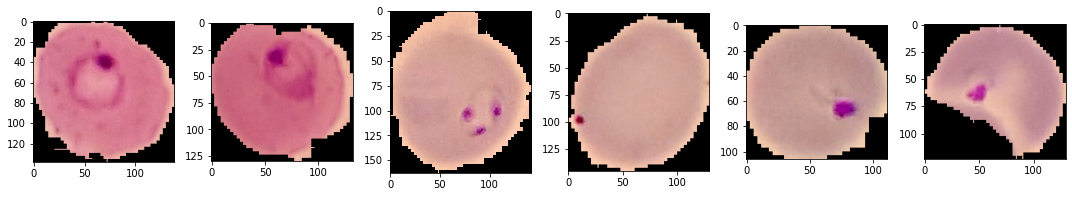

In [ ]:
example_parasitized_cells = parasitized_cells[:6]

plot_examples(example_parasitized_cells, parasitized_dir)

##### Uninfected cells example

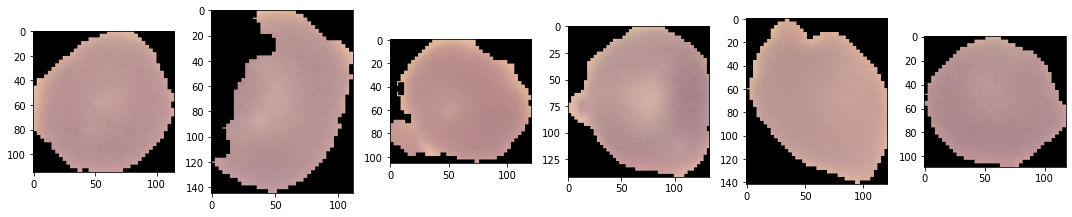

In [ ]:
example_uninfected_cells = uninfected_cells[:6]

plot_examples(example_uninfected_cells, uninfected_dir)

We can see quite significant differences at the pictures. Parasitized cell have visible swings on the surface. These differences are good work for CNNs.

##### Data preprocessing
Data preprocessing and labeling is pretty straightforward. Everything what I have done is resizing to 50x50 images.

In [ ]:
def preprocess_images(images: list, base_path: str, img_label: int, resize: tuple = (50, 50)) -> tuple:
    X, y = [], []
    for image in images:
        try:
            img_arr = plt.imread(os.path.join(base_path, image))
            resized_img = cv2.resize(img_arr, resize)
            y.append(img_label)
            X.append(resized_img)
        except OSError as exc:
            print(exc)
    return X, y

In [ ]:
X_p, y_p = preprocess_images(parasitized_cells, parasitized_dir, 1)
X_u, y_u = preprocess_images(uninfected_cells, uninfected_dir, 0)

In [ ]:
X = np.array([*X_p, *X_u])
y = np.array([*y_p, *y_u])

Splitting data in proporion 7:3

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [ ]:
y_train = np_utils.to_categorical(y_train, num_classes = 2)
y_test = np_utils.to_categorical(y_test, num_classes = 2)

CNN built for image recognition is a simple CNN with two CONV => RELU => POOL => CONV => RELU layers and single fully connected layer. I've also used BatchNormalization layer after each RELU activation making our network train faster, converage more quickly and making activation function more viable. 

In [ ]:
class CNNNet:
    @staticmethod
    def build(width: int, height: int, depth: int, classes: int):
        model = Sequential()
        input_shape = (height, width, depth)
        channel_dimension = -1
        
        if backend.image_data_format() == "channels_first":
            input_shape = (depth, height, width)
            channel_dimension = 1
            
        # first CONV => RELU => POOL => CONV => RELU layer set
        model.add(Conv2D(32, (3, 3), input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization(axis=channel_dimension))
        model.add(Conv2D(32, (3, 3), input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dimension))
        model.add(Dropout(0.2))

        # second CONV => RELU => POOL => CONV => RELU layer set
        model.add(Conv2D(32, (3, 3), input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization(axis=channel_dimension))
        model.add(Conv2D(32, (3, 3), input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dimension))
        model.add(Dropout(0.2))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dimension))
        model.add(Dropout(0.5))
        
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        return model

##### Data augmentation

CNN needs a lot of data. Thanks tu Data Augmentaion process we can genarete enough data for our model. I've tried simple data augmentation (small zooms, small rotations and pretty small horizontal/vertical shifts)

In [ ]:
train_image_generator = ImageDataGenerator(
#         rescale=1/255.,
        fill_mode='nearest',  # fill points outside the boundaries 
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.3, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False  # randomly flip images
)  

validation_image_generator = ImageDataGenerator(
#     rescale=1/255.
)

In [ ]:
train_data = train_image_generator.flow(X_train, y_train, batch_size=1, shuffle=True)
validation_data = validation_image_generator.flow(X_test, y_test, batch_size=1, shuffle=True)

In [ ]:
height, width, depth = 50, 50, 3
classes = 2

model = CNNNet.build(width, height, depth, classes)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
activation_31 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
activation_32 (Activation)   (None, 22, 22, 32)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 22, 22, 32)       

In [ ]:
steps_per_epoch = X_train.shape[0] // 64
adam_optimizer = optimizers.Adam(lr = 0.001, decay = 0.001 / 64)
model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(train_data,
                    epochs=30,
                    steps_per_epoch=50,
                    validation_data=validation_data, 
                    validation_steps=50)



Epoch 1/30
50/50 [==============================] - 3s 53ms/step - loss: 0.6937 - accuracy: 0.5200 - val_loss: 0.5705 - val_accuracy: 0.6000
Epoch 2/30
50/50 [==============================] - 1s 22ms/step - loss: 0.6926 - accuracy: 0.5600 - val_loss: 0.3826 - val_accuracy: 0.6400
Epoch 3/30
50/50 [==============================] - 1s 22ms/step - loss: 0.6875 - accuracy: 0.6400 - val_loss: 1.3452 - val_accuracy: 0.5800
Epoch 4/30
50/50 [==============================] - 1s 22ms/step - loss: 0.6946 - accuracy: 0.4800 - val_loss: 0.1746 - val_accuracy: 0.6400
Epoch 5/30
50/50 [==============================] - 1s 22ms/step - loss: 0.6884 - accuracy: 0.5600 - val_loss: 0.0688 - val_accuracy: 0.5800
Epoch 6/30
50/50 [==============================] - 1s 22ms/step - loss: 0.6907 - accuracy: 0.5600 - val_loss: 3.1921 - val_accuracy: 0.6200
Epoch 7/30
50/50 [==============================] - 1s 22ms/step - loss: 0.6967 - accuracy: 0.5000 - val_loss: 4.1155 - val_accuracy: 0.6400
Epoch 8/30
50

In [ ]:
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('Loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

KeyError: ignored

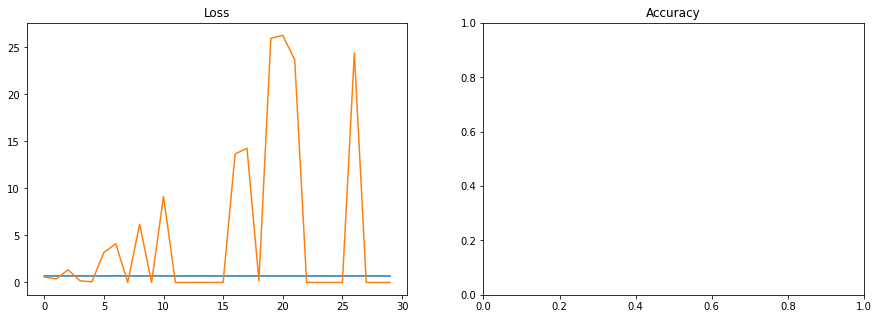

In [ ]:
show_history(history)

In [ ]:
predict = model.evaluate_generator(validation_data, steps=4)

In [ ]:
print(f"Loss on test data set: {predict[0]:.5f}. Accuracy on test dataset: {predict[1] * 100:.2f}%")

Loss on test data set: 0.00000. Accuracy on test dataset: 75.00%


In [ ]:
def show_random_predictions(model, X_test):
    predictions = model.predict(X_test)
    print(predictions)
    for i, row in enumerate(predictions):
        is_parasitized = row[0] <= row[1]
        label = "Parasitized" if is_parasitized else "Uninfected"
        plt.title(label)
        plt.imshow(X_test[i])
        plt.show()

[[1.0000000e+00 1.6737024e-14]
 [2.2395523e-12 1.0000000e+00]
 [2.2395523e-12 1.0000000e+00]
 [2.2395523e-12 1.0000000e+00]
 [2.2395523e-12 1.0000000e+00]]


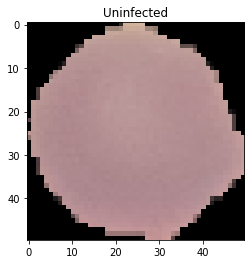

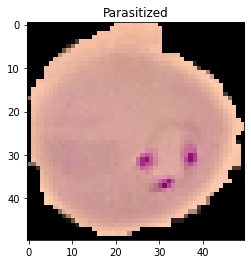

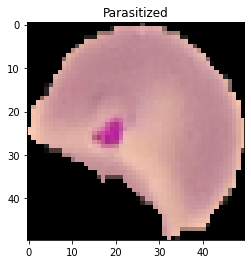

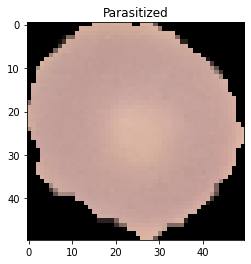

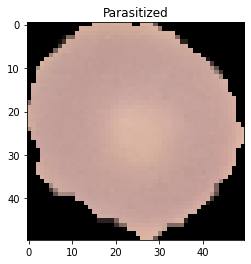

In [ ]:
random_data = X_test[np.random.randint(X_test.shape[0], size=5), :]
show_random_predictions(model, random_data)